In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras import backend as K
import keras.layers as layers
from keras.models import Model
from keras import Sequential
from keras.layers import Lambda, Dense, Flatten
from sklearn.metrics import roc_curve, roc_auc_score
from keras.losses import binary_crossentropy
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.models import model_from_json
import pandas as pd
from sklearn import preprocessing
from matplotlib import gridspec
from matplotlib import patches

plt.rcParams["font.family"] = "serif"

Using TensorFlow backend.
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

In [2]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

## Gaussian example

In [3]:
epsilon = 0.1
N = 100000

myoneD_signal = np.random.normal(epsilon,1,N)
myoneD_background = np.random.normal(-epsilon,1,N)

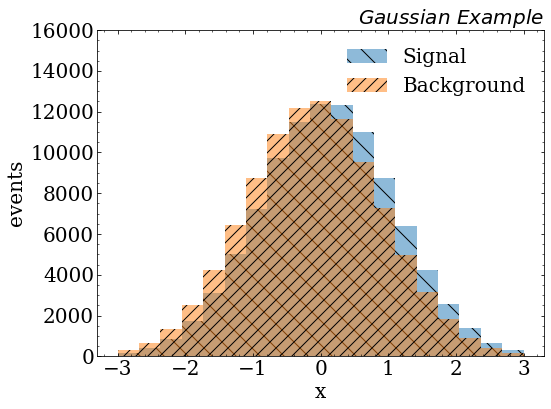

In [4]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(myoneD_signal,bins=np.linspace(-3,3,20),alpha=0.5,label="Signal",hatch='\\')
plt.hist(myoneD_background,bins=np.linspace(-3,3,20),alpha=0.5,label="Background",hatch='//')
plt.ylim([0,16000])
plt.xlabel("x",fontsize=20)
plt.ylabel("events",fontsize=20)
plt.legend(frameon=False,fontsize=20)
plt.title(r"$Gaussian$ $Example$",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/Gaussian_Xhist.pdf",bbox_inches='tight')

In [5]:
X_1D = np.concatenate([myoneD_signal,myoneD_background])
Y_1D = np.concatenate([np.ones(len(myoneD_signal)),np.zeros(len(myoneD_background))])

n = 10
if (N % n != 0):
    print("That is not a valid choice!")
    
X_nD = np.reshape(X_1D,[int(len(X_1D)/n),n])
Y_nD = np.concatenate([np.ones(int(len(myoneD_signal)/n)),np.zeros(int(len(myoneD_background)/n))])

X_1D_train, X_1D_val, Y_1D_train, Y_1D_val = train_test_split(X_1D, Y_1D, test_size=0.5)
X_nD_train, X_nD_val, Y_nD_train, Y_nD_val = train_test_split(X_nD, Y_nD, test_size=0.5)

In [6]:
model1D = Sequential()
model1D.add(Dense(128, activation='relu',input_shape =(1,))) 
model1D.add(Dense(128, activation='relu'))
model1D.add(Dense(1, activation='sigmoid'))
model1D.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_model1D= model1D.fit(X_1D_train, Y_1D_train, epochs=2, batch_size=128,validation_data=(X_1D_val, Y_1D_val))

Train on 100000 samples, validate on 100000 samples
Epoch 1/2
100000/100000 [==============================] - 5s 52us/step - loss: 0.6887 - acc: 0.5382 - val_loss: 0.6888 - val_acc: 0.5383
Epoch 2/2
100000/100000 [==============================] - 5s 46us/step - loss: 0.6884 - acc: 0.5395 - val_loss: 0.6892 - val_acc: 0.5393


In [7]:
modelnD = Sequential()
modelnD.add(Dense(128, activation='relu',input_shape =(n,))) 
modelnD.add(Dense(128, activation='relu'))
modelnD.add(Dense(1, activation='sigmoid'))
modelnD.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_modelnD= modelnD.fit(X_nD_train, Y_nD_train, epochs=2, batch_size=128,validation_data=(X_nD_val, Y_nD_val))

Train on 10000 samples, validate on 10000 samples
Epoch 1/2
10000/10000 [==============================] - 1s 79us/step - loss: 0.6573 - acc: 0.5991 - val_loss: 0.6472 - val_acc: 0.6160
Epoch 2/2
10000/10000 [==============================] - 0s 49us/step - loss: 0.6481 - acc: 0.6126 - val_loss: 0.6463 - val_acc: 0.6217


In [8]:
scores_1D = model1D.predict(X_1D_val)
scores_nD = modelnD.predict(X_nD_val)

In [9]:
scores_1D_fromnD = model1D.predict(np.reshape(X_nD_val,[n*len(X_nD_val)]))

In [10]:
scores_1D_fromnD = np.reshape(scores_1D_fromnD,[int(len(scores_1D_fromnD)/n),n])

In [11]:
scaled_up = np.array([np.prod(scores_1D_fromnD[i,:] / (1.-scores_1D_fromnD[i,:])) for i in range(len(scores_1D_fromnD))])

In [12]:
fpr_1D, tpr_1D, _ = roc_curve(Y_1D_val, scores_1D)
fpr_nD, tpr_nD, _ = roc_curve(Y_nD_val, scores_nD)
fpr_nD_from1D, tpr_nD_from1D, _ = roc_curve(Y_nD_val, scaled_up)

In [137]:
#Save everything
np.save("ensemblelearning/Y_1D_val",Y_1D_val)
np.save("ensemblelearning/X_1D_val",Y_1D_val)
np.save("ensemblelearning/Y_1D_train",Y_1D_train)
np.save("ensemblelearning/X_1D_train",X_1D_train)

np.save("ensemblelearning/Y_nD_val",Y_nD_val)
np.save("ensemblelearning/X_nD_val",Y_nD_val)
np.save("ensemblelearning/Y_nD_train",Y_nD_train)
np.save("ensemblelearning/X_nD_train",X_nD_train)

model_json = model1D.to_json()
with open("ensemblelearning/model1D.json", "w") as json_file:
    json_file.write(model_json)
model1D.save_weights("ensemblelearning/model1D.h5")

model_json = modelnD.to_json()
with open("ensemblelearning/modelnD.json", "w") as json_file:
    json_file.write(model_json)
modelnD.save_weights("ensemblelearning/modelnD.h5")

In [138]:
#Load everything
Y_1D_val = np.load("ensemblelearning/Y_1D_val.npy")
Y_1D_val = np.load("ensemblelearning/X_1D_val.npy")
Y_1D_train = np.load("ensemblelearning/Y_1D_train.npy")
X_1D_train = np.load("ensemblelearning/X_1D_train.npy")

Y_nD_val = np.load("ensemblelearning/Y_nD_val.npy")
Y_nD_val = np.load("ensemblelearning/X_nD_val.npy")
Y_nD_train = np.load("ensemblelearning/Y_nD_train.npy")
X_nD_train = np.load("ensemblelearning/X_nD_train.npy")

json_file = open('ensemblelearning/model1D.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model1D = model_from_json(loaded_model_json)
model1D.load_weights("ensemblelearning/model1D.h5")

json_file = open('ensemblelearning/modelnD.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
modelnD = model_from_json(loaded_model_json)
modelnD.load_weights("ensemblelearning/modelnD.h5")

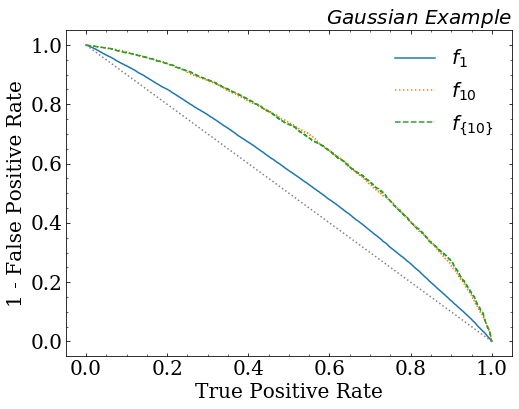

In [13]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(tpr_1D,1-fpr_1D,label="$f_{1}$")
plt.plot(tpr_nD,1-fpr_nD,label="$f_{10}$",ls=":")
plt.plot(tpr_nD_from1D,1-fpr_nD_from1D,label="$f_{\{10\}}$",ls="--")
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=20)
plt.ylabel("1 - False Positive Rate",fontsize=20)
plt.legend(frameon=False)
plt.title(r"$Gaussian$ $Example$",loc="right",fontsize=20)

plt.legend(frameon=False,fontsize=20)
plt.savefig("ensembleLearnPlots/Gaussian_ROC.pdf",bbox_inches='tight')

In [14]:
#Papers that claim ensembling is useful:

#1810.00835
#1910.11530
#1912.10625
#2007.14586
#2011.04666

## BSM example

In [15]:
features_sig=pd.read_hdf("/data1/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_Wprime_features.h5")
features_bg=pd.read_hdf("/data1/bpnachman/anomaly/events_anomalydetection_DelphesPythia8_v2_qcd_features.h5")

In [16]:
def load_data(input_frame):
    dataset = input_frame[["mj1","tau1j1","tau2j1","mj2","tau1j2","tau2j2"]]
    dataset["mjj"] = (((input_frame["pxj1"]**2+input_frame["pyj1"]**2+input_frame["pzj1"]**2+input_frame["mj1"]**2)**0.5+(input_frame["pxj2"]**2+input_frame["pyj2"]**2+input_frame["pzj2"]**2+input_frame["mj2"]**2)**0.5)**2-(input_frame["pxj1"]+input_frame["pxj2"])**2-(input_frame["pyj1"]+input_frame["pyj2"])**2-(input_frame["pzj1"]+input_frame["pzj2"])**2)**0.5/1000.
    dataset["mjTwo"] = dataset[["mj1", "mj2"]].max(axis=1)
    dataset["mjOne"] = dataset[["mj1", "mj2"]].min(axis=1)
    dataset["mjDelta"] = dataset["mjTwo"] - dataset["mjOne"]
    dataset["tau1jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jOne"] = (dataset["mjOne"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjOne"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau1jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau1j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau1j2"]
    dataset["tau2jTwo"] = (dataset["mjTwo"] == dataset["mj1"])*dataset["tau2j1"]+(dataset["mjTwo"] == dataset["mj2"])*dataset["tau2j2"]
    dataset["tau21jOne"] = dataset["tau2jOne"]/dataset["tau1jOne"]
    dataset["tau21jTwo"] = dataset["tau2jTwo"]/dataset["tau1jTwo"]
    dataset["mjTwo"] = dataset["mjTwo"]/1000.
    dataset["mjOne"] = dataset["mjOne"]/1000.
    dataset["mjDelta"] = dataset["mjDelta"]/1000.
    dataset = dataset.fillna(0)
    dataset = dataset[["mjj","mjOne","mjDelta","tau21jOne","tau21jTwo"]]
    return dataset.to_numpy()

In [17]:
dataset_bg=load_data(features_bg)
dataset_bg=np.hstack((dataset_bg,np.zeros((len(dataset_bg),1))))

dataset_sig=load_data(features_sig)
dataset_sig=np.hstack((dataset_sig,np.ones((len(dataset_sig),1))))

/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCop

In [18]:
SR_low = 3.3
SR_high = 3.7

n_phys = 3

X_sig_SR = dataset_sig[(dataset_sig[:,0] > SR_low)*(dataset_sig[:,0] < SR_high)][:,1:5]
X_bg_SR = dataset_bg[(dataset_bg[:,0] > SR_low)*(dataset_bg[:,0] < SR_high)][:,1:5]

X_sig_SR = X_sig_SR[0:len(X_sig_SR) - len(X_sig_SR) % n_phys]
X_bg_SR = X_bg_SR[0:len(X_bg_SR) - len(X_bg_SR) % n_phys]

X_1D_phys = np.concatenate([X_sig_SR,X_bg_SR])
Y_1D_phys = np.concatenate([np.ones(len(X_sig_SR)),np.zeros(len(X_bg_SR))])

X_nD_phys = np.reshape(X_1D_phys,[int(len(X_1D_phys)/n_phys),4*n_phys])
Y_nD_phys = np.concatenate([np.ones(int(len(X_sig_SR)/n_phys)),np.zeros(int(len(X_bg_SR)/n_phys))])

#Try standardizing?
scaler = preprocessing.StandardScaler().fit(X_nD_phys)
X_nD_phys = scaler.transform(X_nD_phys)

scaler1D = preprocessing.StandardScaler().fit(X_1D_phys)
X_1D_phys = scaler1D.transform(X_1D_phys)

X_1D_train_phys, X_1D_val_phys, Y_1D_train_phys, Y_1D_val_phys = train_test_split(X_1D_phys, Y_1D_phys, test_size=0.5)
X_nD_train_phys, X_nD_val_phys, Y_nD_train_phys, Y_nD_val_phys = train_test_split(X_nD_phys, Y_nD_phys, test_size=0.5)

#Try sorting the n-dimensional case based on mJ1?
X_nD_train_sort_phys = np.array([np.reshape(sorted(np.reshape(X_nD_train_phys[i],[n_phys,4]), key=lambda x: x[0]),[n_phys*4]) for i in range(len(X_nD_train_phys))])
X_nD_val_sort_phys = np.array([np.reshape(sorted(np.reshape(X_nD_val_phys[i],[n_phys,4]), key=lambda x: x[0]),[n_phys*4]) for i in range(len(X_nD_val_phys))])

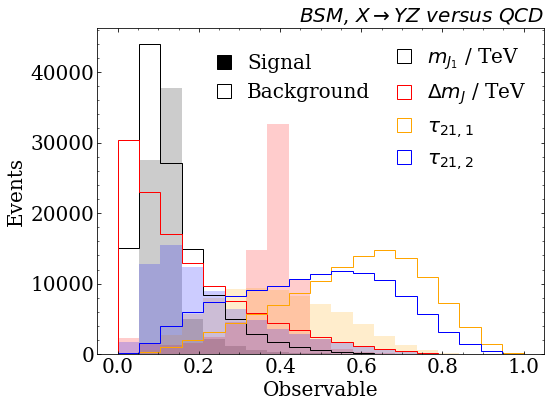

In [19]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.hist(X_sig_SR[:,0],bins=np.linspace(0,1,20),alpha=0.2,color="black")
plt.hist(X_sig_SR[:,1],bins=np.linspace(0,1,20),alpha=0.2,color="red")
plt.hist(X_sig_SR[:,2],bins=np.linspace(0,1,20),alpha=0.2,color="orange")
plt.hist(X_sig_SR[:,3],bins=np.linspace(0,1,20),alpha=0.2,color="blue")

plt.hist(X_bg_SR[:,0],bins=np.linspace(0,1,20),color="black",histtype='step',label=r"$m_{J_1}$ / TeV")
plt.hist(X_bg_SR[:,1],bins=np.linspace(0,1,20),color="red",histtype='step',label=r"$\Delta m_J$ / TeV")
plt.hist(X_bg_SR[:,2],bins=np.linspace(0,1,20),color="orange",histtype='step',label=r"$\tau_{21,1}$")
plt.hist(X_bg_SR[:,3],bins=np.linspace(0,1,20),color="blue",histtype='step',label=r"$\tau_{21,2}$")

plt.xlabel("Observable",fontsize=20)
plt.ylabel("Events",fontsize=20)
leg = plt.legend(frameon=False,fontsize=20, handlelength=0.7)

x = patches.Patch(color='black', label='Signal',fill=True)
x2 = patches.Patch(color='black', label='Background',fill=False)

leg2 = plt.legend(handles=[x,x2],loc=(0.25, 0.75),fontsize=20,frameon=False, handlelength=0.7)
plt.gca().add_artist(leg)
plt.title(r"$BSM$, $X\rightarrow YZ$ $versus$ $QCD$",loc="right",fontsize=20)

plt.savefig("ensembleLearnPlots/BSM_Hist.pdf",bbox_inches='tight')

In [20]:
model_1D_phys = Sequential()
model_1D_phys.add(Dense(64, input_dim=4, activation='relu')) 
model_1D_phys.add(Dense(64, activation='relu'))
model_1D_phys.add(Dense(64, activation='relu'))
model_1D_phys.add(Dense(64, activation='relu'))
model_1D_phys.add(Dense(1, activation='sigmoid'))
model_1D_phys.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_1D_phys.fit(X_1D_train_phys,Y_1D_train_phys, epochs=50, batch_size=int(0.1*len(X_1D_train_phys)),validation_data=(X_1D_val_phys,Y_1D_val_phys))

Train on 98323 samples, validate on 98324 samples
Epoch 1/50
98323/98323 [==============================] - 1s 5us/step - loss: 0.6619 - acc: 0.7017 - val_loss: 0.5880 - val_acc: 0.8551
Epoch 2/50
98323/98323 [==============================] - 0s 2us/step - loss: 0.5356 - acc: 0.8561 - val_loss: 0.4523 - val_acc: 0.8640
Epoch 3/50
98323/98323 [==============================] - 0s 1us/step - loss: 0.4118 - acc: 0.8640 - val_loss: 0.3560 - val_acc: 0.8710
Epoch 4/50
98323/98323 [==============================] - 0s 2us/step - loss: 0.3371 - acc: 0.8717 - val_loss: 0.3258 - val_acc: 0.8708
Epoch 5/50
98323/98323 [==============================] - 0s 2us/step - loss: 0.3220 - acc: 0.8743 - val_loss: 0.3167 - val_acc: 0.8750
Epoch 6/50
98323/98323 [==============================] - 0s 2us/step - loss: 0.3174 - acc: 0.8730 - val_loss: 0.3047 - val_acc: 0.8807
Epoch 7/50
98323/98323 [==============================] - 0s 2us/step - loss: 0.3094 - acc: 0.8815 - val_loss: 0.3030 - val_acc: 0.884

In [21]:
model_nD_phys = Sequential()
model_nD_phys.add(Dense(64, input_dim=4*n_phys, activation='relu')) 
model_nD_phys.add(Dense(64, activation='relu'))
model_nD_phys.add(Dense(128, activation='relu'))
model_nD_phys.add(Dense(64, activation='relu'))
model_nD_phys.add(Dense(1, activation='sigmoid'))
model_nD_phys.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nD_phys.fit(X_nD_train_phys,Y_nD_train_phys, epochs=500, batch_size=int(0.1*len(X_nD_train_phys)),validation_data=(X_nD_val_phys,Y_nD_val_phys))

Train on 32774 samples, validate on 32775 samples
Epoch 1/500
32774/32774 [==============================] - 0s 15us/step - loss: 0.5514 - acc: 0.8579 - val_loss: 0.3589 - val_acc: 0.9251
Epoch 2/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.2593 - acc: 0.9348 - val_loss: 0.1565 - val_acc: 0.9479
Epoch 3/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.1401 - acc: 0.9496 - val_loss: 0.1255 - val_acc: 0.9522
Epoch 4/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.1217 - acc: 0.9543 - val_loss: 0.1169 - val_acc: 0.9555
Epoch 5/500
32774/32774 [==============================] - 0s 4us/step - loss: 0.1144 - acc: 0.9567 - val_loss: 0.1108 - val_acc: 0.9582
Epoch 6/500
32774/32774 [==============================] - 0s 4us/step - loss: 0.1081 - acc: 0.9588 - val_loss: 0.1063 - val_acc: 0.9602
Epoch 7/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.1038 - acc: 0.9603 - val_loss: 0.1026 - val_ac

32774/32774 [==============================] - 0s 3us/step - loss: 0.0459 - acc: 0.9837 - val_loss: 0.0551 - val_acc: 0.9800
Epoch 61/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0452 - acc: 0.9842 - val_loss: 0.0549 - val_acc: 0.9802
Epoch 62/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0442 - acc: 0.9844 - val_loss: 0.0545 - val_acc: 0.9807
Epoch 63/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0437 - acc: 0.9847 - val_loss: 0.0573 - val_acc: 0.9787
Epoch 64/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0654 - acc: 0.9752 - val_loss: 0.0809 - val_acc: 0.9727
Epoch 65/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0595 - acc: 0.9780 - val_loss: 0.0669 - val_acc: 0.9767
Epoch 66/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0523 - acc: 0.9812 - val_loss: 0.0620 - val_acc: 0.9787
Epoch 67/500
32774/32774 [=====================

32774/32774 [==============================] - 0s 3us/step - loss: 0.0320 - acc: 0.9900 - val_loss: 0.0494 - val_acc: 0.9832
Epoch 120/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0341 - acc: 0.9883 - val_loss: 0.0520 - val_acc: 0.9820
Epoch 121/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0332 - acc: 0.9892 - val_loss: 0.0527 - val_acc: 0.9820
Epoch 122/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0452 - acc: 0.9855 - val_loss: 0.0619 - val_acc: 0.9796
Epoch 123/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0443 - acc: 0.9864 - val_loss: 0.0539 - val_acc: 0.9826
Epoch 124/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0371 - acc: 0.9883 - val_loss: 0.0522 - val_acc: 0.9825
Epoch 125/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0357 - acc: 0.9876 - val_loss: 0.0509 - val_acc: 0.9822
Epoch 126/500
32774/32774 [==============

32774/32774 [==============================] - 0s 3us/step - loss: 0.0281 - acc: 0.9909 - val_loss: 0.0480 - val_acc: 0.9838
Epoch 179/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0273 - acc: 0.9912 - val_loss: 0.0477 - val_acc: 0.9837
Epoch 180/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0267 - acc: 0.9914 - val_loss: 0.0476 - val_acc: 0.9836
Epoch 181/500
32774/32774 [==============================] - 0s 4us/step - loss: 0.0259 - acc: 0.9918 - val_loss: 0.0477 - val_acc: 0.9836
Epoch 182/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0254 - acc: 0.9918 - val_loss: 0.0476 - val_acc: 0.9836
Epoch 183/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0250 - acc: 0.9921 - val_loss: 0.0478 - val_acc: 0.9837
Epoch 184/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0247 - acc: 0.9921 - val_loss: 0.0479 - val_acc: 0.9838
Epoch 185/500
32774/32774 [==============

32774/32774 [==============================] - 0s 3us/step - loss: 0.0231 - acc: 0.9925 - val_loss: 0.0490 - val_acc: 0.9837
Epoch 238/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0224 - acc: 0.9926 - val_loss: 0.0494 - val_acc: 0.9836
Epoch 239/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0257 - acc: 0.9911 - val_loss: 0.0516 - val_acc: 0.9835
Epoch 240/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0259 - acc: 0.9905 - val_loss: 0.0507 - val_acc: 0.9838
Epoch 241/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0235 - acc: 0.9921 - val_loss: 0.0495 - val_acc: 0.9842
Epoch 242/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0219 - acc: 0.9923 - val_loss: 0.0489 - val_acc: 0.9837
Epoch 243/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0216 - acc: 0.9930 - val_loss: 0.0502 - val_acc: 0.9842
Epoch 244/500
32774/32774 [==============

32774/32774 [==============================] - 0s 3us/step - loss: 0.0354 - acc: 0.9873 - val_loss: 0.0527 - val_acc: 0.9817
Epoch 297/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0327 - acc: 0.9883 - val_loss: 0.0515 - val_acc: 0.9817
Epoch 298/500
32774/32774 [==============================] - 0s 4us/step - loss: 0.0313 - acc: 0.9892 - val_loss: 0.0506 - val_acc: 0.9819
Epoch 299/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0301 - acc: 0.9896 - val_loss: 0.0502 - val_acc: 0.9824
Epoch 300/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0293 - acc: 0.9900 - val_loss: 0.0500 - val_acc: 0.9822
Epoch 301/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0285 - acc: 0.9906 - val_loss: 0.0499 - val_acc: 0.9822
Epoch 302/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0277 - acc: 0.9908 - val_loss: 0.0506 - val_acc: 0.9830
Epoch 303/500
32774/32774 [==============

32774/32774 [==============================] - 0s 3us/step - loss: 0.0158 - acc: 0.9952 - val_loss: 0.0517 - val_acc: 0.9846
Epoch 356/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0153 - acc: 0.9954 - val_loss: 0.0517 - val_acc: 0.9846
Epoch 357/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0150 - acc: 0.9956 - val_loss: 0.0517 - val_acc: 0.9847
Epoch 358/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0148 - acc: 0.9957 - val_loss: 0.0519 - val_acc: 0.9848
Epoch 359/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0146 - acc: 0.9959 - val_loss: 0.0521 - val_acc: 0.9849
Epoch 360/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0144 - acc: 0.9959 - val_loss: 0.0521 - val_acc: 0.9848
Epoch 361/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0142 - acc: 0.9959 - val_loss: 0.0523 - val_acc: 0.9846
Epoch 362/500
32774/32774 [==============

32774/32774 [==============================] - 0s 3us/step - loss: 0.0091 - acc: 0.9978 - val_loss: 0.0595 - val_acc: 0.9850
Epoch 415/500
32774/32774 [==============================] - 0s 4us/step - loss: 0.0090 - acc: 0.9978 - val_loss: 0.0590 - val_acc: 0.9843
Epoch 416/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0087 - acc: 0.9980 - val_loss: 0.0590 - val_acc: 0.9848
Epoch 417/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0084 - acc: 0.9980 - val_loss: 0.0591 - val_acc: 0.9845
Epoch 418/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0083 - acc: 0.9980 - val_loss: 0.0593 - val_acc: 0.9846
Epoch 419/500
32774/32774 [==============================] - 0s 4us/step - loss: 0.0082 - acc: 0.9983 - val_loss: 0.0596 - val_acc: 0.9847
Epoch 420/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0081 - acc: 0.9982 - val_loss: 0.0618 - val_acc: 0.9850
Epoch 421/500
32774/32774 [==============

32774/32774 [==============================] - 0s 3us/step - loss: 0.0200 - acc: 0.9931 - val_loss: 0.0598 - val_acc: 0.9823
Epoch 474/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0167 - acc: 0.9945 - val_loss: 0.0583 - val_acc: 0.9828
Epoch 475/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0148 - acc: 0.9951 - val_loss: 0.0573 - val_acc: 0.9834
Epoch 476/500
32774/32774 [==============================] - 0s 4us/step - loss: 0.0135 - acc: 0.9957 - val_loss: 0.0573 - val_acc: 0.9832
Epoch 477/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0130 - acc: 0.9960 - val_loss: 0.0597 - val_acc: 0.9834
Epoch 478/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0183 - acc: 0.9940 - val_loss: 0.0633 - val_acc: 0.9836
Epoch 479/500
32774/32774 [==============================] - 0s 3us/step - loss: 0.0188 - acc: 0.9940 - val_loss: 0.0613 - val_acc: 0.9834
Epoch 480/500
32774/32774 [==============

In [22]:
model_nD_sort_phys = Sequential()
model_nD_sort_phys.add(Dense(64, input_dim=4*n_phys, activation='relu')) 
model_nD_sort_phys.add(Dense(64, activation='relu'))
model_nD_sort_phys.add(Dense(128, activation='relu'))
model_nD_sort_phys.add(Dense(64, activation='relu'))
model_nD_sort_phys.add(Dense(1, activation='sigmoid'))
model_nD_sort_phys.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nD_sort_phys.fit(X_nD_train_sort_phys,Y_nD_train_phys, epochs=50, batch_size=int(0.1*len(X_nD_train_sort_phys)),validation_data=(X_nD_val_sort_phys,Y_nD_val_phys))

Train on 32774 samples, validate on 32775 samples
Epoch 1/50
32774/32774 [==============================] - 1s 18us/step - loss: 0.6195 - acc: 0.6646 - val_loss: 0.4613 - val_acc: 0.8647
Epoch 2/50
32774/32774 [==============================] - 0s 3us/step - loss: 0.3638 - acc: 0.9003 - val_loss: 0.2165 - val_acc: 0.9499
Epoch 3/50
32774/32774 [==============================] - 0s 4us/step - loss: 0.1623 - acc: 0.9552 - val_loss: 0.1145 - val_acc: 0.9577
Epoch 4/50
32774/32774 [==============================] - 0s 4us/step - loss: 0.1082 - acc: 0.9590 - val_loss: 0.1026 - val_acc: 0.9617
Epoch 5/50
32774/32774 [==============================] - 0s 4us/step - loss: 0.1041 - acc: 0.9609 - val_loss: 0.0979 - val_acc: 0.9632
Epoch 6/50
32774/32774 [==============================] - 0s 4us/step - loss: 0.0975 - acc: 0.9634 - val_loss: 0.0922 - val_acc: 0.9651
Epoch 7/50
32774/32774 [==============================] - 0s 4us/step - loss: 0.0904 - acc: 0.9655 - val_loss: 0.0903 - val_acc: 0.96

In [23]:
scores_1D_phys = model_1D_phys.predict(X_1D_val_phys,batch_size=int(0.1*len(X_1D_train_phys)))
scores_nD_phys = model_nD_phys.predict(X_nD_val_phys,batch_size=int(0.1*len(X_nD_train_phys)))
scores_nD_sort_phys = model_nD_sort_phys.predict(X_nD_val_sort_phys,batch_size=int(0.1*len(X_nD_train_sort_phys)))

In [24]:
#scores_1D_fromnD_phys = model_1D_phys.predict(np.reshape(X_nD_val_phys,[n_phys*len(X_nD_val_phys),4]),batch_size=int(0.1*len(X_nD_train_phys)))
scores_1D_fromnD_phys = model_1D_phys.predict(scaler1D.transform(np.reshape(scaler.inverse_transform(X_nD_val_phys),[n_phys*len(X_nD_val_phys),4])),batch_size=int(0.1*len(X_nD_train_phys)))

In [25]:
scores_1D_fromnD_phys = np.reshape(scores_1D_fromnD_phys,[int(len(scores_1D_fromnD_phys)/n_phys),n_phys])

In [26]:
scaled_up_phys = np.array([np.prod(scores_1D_fromnD_phys[i,:] / (1.-scores_1D_fromnD_phys[i,:])) for i in range(len(scores_1D_fromnD_phys))])

In [27]:
fpr_1D_phys, tpr_1D_phys, _ = roc_curve(Y_1D_val_phys, scores_1D_phys)
fpr_nD_phys, tpr_nD_phys, _ = roc_curve(Y_nD_val_phys, scores_nD_phys)
fpr_nD_sort_phys, tpr_nD_sort_phys, _ = roc_curve(Y_nD_val_phys, scores_nD_sort_phys)
fpr_nD_from1D_phys, tpr_nD_from1D_phys, _ = roc_curve(Y_nD_val_phys, scaled_up_phys)

/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


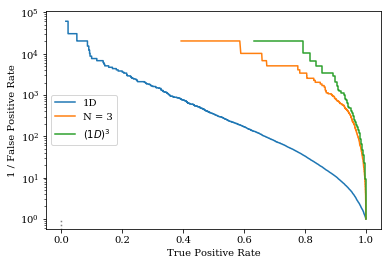

In [28]:
plt.plot(tpr_1D_phys,1./fpr_1D_phys,label="1D")
plt.plot(tpr_nD_phys,1./fpr_nD_phys,label="N = "+str(n_phys))
plt.plot(tpr_nD_from1D_phys,1./fpr_nD_from1D_phys,label="$(1D)^{"+str(n_phys)+"}$")
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate")
plt.ylabel("1 / False Positive Rate")
plt.yscale("log")
plt.legend()

In [29]:
#maybe try with a PFN?

In [30]:
import energyflow as ef
from energyflow.archs import PFN, EFN
from energyflow.utils import to_categorical

In [31]:
np.shape(X_nD_val_phys)

(32775, 12)

In [32]:
X_nD_val_phys_pfn = np.reshape(X_nD_val_phys,[len(X_nD_val_phys),n_phys,4])
X_nD_train_phys_pfn = np.reshape(X_nD_train_phys,[len(X_nD_train_phys),n_phys,4])

In [33]:
X_nD_val_phys_pfn[0]

array([[ 0.0232516 ,  0.57254116, -0.6975219 , -1.11152641],
       [ 0.14183378,  0.83389831, -0.90795728, -1.09508294],
       [-0.39255246,  1.12209154, -1.10957885, -1.11872501]])

In [114]:
Phi_sizes, F_sizes = (100, 100, 128), (100, 100, 100)

In [115]:
pfn = PFN(input_dim=X_nD_val_phys_pfn.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes,F_dropouts=0.1,latent_dropout=0.1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_47 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_47[0][0]              
__________________________________________________________________________________________________
activation

In [116]:
num_epoch = 200
batch_size = int(0.1*len(X_nD_train_phys_pfn)) #was 5000
historyf = pfn.fit(X_nD_train_phys_pfn, to_categorical(Y_nD_train_phys,2),
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_nD_val_phys_pfn, to_categorical(Y_nD_val_phys,2)),
        verbose=1)

Train on 32774 samples, validate on 32775 samples
Epoch 1/200
32774/32774 [==============================] - 1s 42us/step - loss: 0.6590 - acc: 0.7792 - val_loss: 0.1494 - val_acc: 0.9526
Epoch 2/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.1760 - acc: 0.9416 - val_loss: 0.1067 - val_acc: 0.9605
Epoch 3/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.1271 - acc: 0.9536 - val_loss: 0.0883 - val_acc: 0.9678
Epoch 4/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.1018 - acc: 0.9618 - val_loss: 0.0756 - val_acc: 0.9725
Epoch 5/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0917 - acc: 0.9679 - val_loss: 0.0664 - val_acc: 0.9752
Epoch 6/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0808 - acc: 0.9706 - val_loss: 0.0596 - val_acc: 0.9784
Epoch 7/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0729 - acc: 0.9742 - val_loss: 0.0561 - val_ac

32774/32774 [==============================] - 0s 5us/step - loss: 0.0471 - acc: 0.9842 - val_loss: 0.0409 - val_acc: 0.9853
Epoch 61/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0417 - acc: 0.9854 - val_loss: 0.0386 - val_acc: 0.9860
Epoch 62/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0389 - acc: 0.9860 - val_loss: 0.0387 - val_acc: 0.9861
Epoch 63/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0396 - acc: 0.9862 - val_loss: 0.0391 - val_acc: 0.9861
Epoch 64/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0388 - acc: 0.9857 - val_loss: 0.0374 - val_acc: 0.9867
Epoch 65/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0384 - acc: 0.9862 - val_loss: 0.0366 - val_acc: 0.9869
Epoch 66/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0381 - acc: 0.9863 - val_loss: 0.0364 - val_acc: 0.9870
Epoch 67/200
32774/32774 [=====================

32774/32774 [==============================] - 0s 5us/step - loss: 0.0343 - acc: 0.9873 - val_loss: 0.0344 - val_acc: 0.9878
Epoch 120/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0336 - acc: 0.9882 - val_loss: 0.0339 - val_acc: 0.9881
Epoch 121/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0333 - acc: 0.9878 - val_loss: 0.0338 - val_acc: 0.9880
Epoch 122/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0329 - acc: 0.9885 - val_loss: 0.0363 - val_acc: 0.9875
Epoch 123/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0387 - acc: 0.9862 - val_loss: 0.0413 - val_acc: 0.9853
Epoch 124/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0373 - acc: 0.9864 - val_loss: 0.0376 - val_acc: 0.9867
Epoch 125/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0341 - acc: 0.9873 - val_loss: 0.0359 - val_acc: 0.9867
Epoch 126/200
32774/32774 [==============

32774/32774 [==============================] - 0s 5us/step - loss: 0.0304 - acc: 0.9891 - val_loss: 0.0335 - val_acc: 0.9888
Epoch 179/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0289 - acc: 0.9896 - val_loss: 0.0329 - val_acc: 0.9883
Epoch 180/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0284 - acc: 0.9898 - val_loss: 0.0325 - val_acc: 0.9887
Epoch 181/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0276 - acc: 0.9899 - val_loss: 0.0327 - val_acc: 0.9885
Epoch 182/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0276 - acc: 0.9897 - val_loss: 0.0327 - val_acc: 0.9891
Epoch 183/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0270 - acc: 0.9903 - val_loss: 0.0328 - val_acc: 0.9884
Epoch 184/200
32774/32774 [==============================] - 0s 5us/step - loss: 0.0271 - acc: 0.9902 - val_loss: 0.0325 - val_acc: 0.9890
Epoch 185/200
32774/32774 [==============

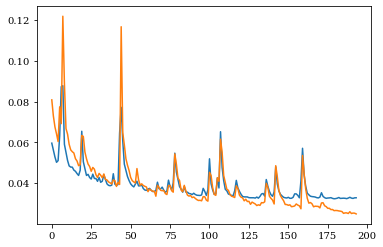

In [117]:
plt.plot(historyf.history['val_loss'][5:-1])
plt.plot(historyf.history['loss'][5:-1])

In [118]:
scores_nD_phys_pfn = pfn.predict(X_nD_val_phys_pfn,batch_size=int(0.1*len(X_nD_train_phys)))

In [119]:
fpr_nD_phys_pfn, tpr_nD_phys_pfn, _ = roc_curve(Y_nD_val_phys, scores_nD_phys_pfn[:,1])

In [144]:
#Save everything
np.save("ensemblelearning/Y_1D_val_phys",Y_1D_val_phys)
np.save("ensemblelearning/X_1D_val_phys",Y_1D_val_phys)
np.save("ensemblelearning/Y_1D_train_phys",Y_1D_train_phys)
np.save("ensemblelearning/X_1D_train_phys",X_1D_train_phys)

np.save("ensemblelearning/Y_nD_val_phys",Y_nD_val_phys)
np.save("ensemblelearning/X_nD_val_phys",Y_nD_val_phys)
np.save("ensemblelearning/Y_nD_train_phys",Y_nD_train_phys)
np.save("ensemblelearning/X_nD_train_phys",X_nD_train_phys)

model_json = model_1D_phys.to_json()
with open("ensemblelearning/model_1D_phys.json", "w") as json_file:
    json_file.write(model_json)
model_1D_phys.save_weights("ensemblelearning/model_1D_phys.h5")

model_json = model_nD_phys.to_json()
with open("ensemblelearning/model_nD_phys.json", "w") as json_file:
    json_file.write(model_json)
model_nD_phys.save_weights("ensemblelearning/model_nD_phys.h5")

model_json = model_nD_sort_phys.to_json()
with open("ensemblelearning/model_nD_sort_phys.json", "w") as json_file:
    json_file.write(model_json)
model_nD_sort_phys.save_weights("ensemblelearning/model_nD_sort_phys.h5")

model_json = pfn.model.to_json()
with open("ensemblelearning/model_pfn.json", "w") as json_file:
    json_file.write(model_json)
pfn.model.save_weights("ensemblelearning/model_pfn.h5")

#This needs to be run later
#model_json = pfn_v2.model.to_json()
#with open("ensemblelearning/model_pfn_v2.json", "w") as json_file:
#    json_file.write(model_json)
#pfn_v2.model.save_weights("ensemblelearning/model_pfn_v2.h5")

/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


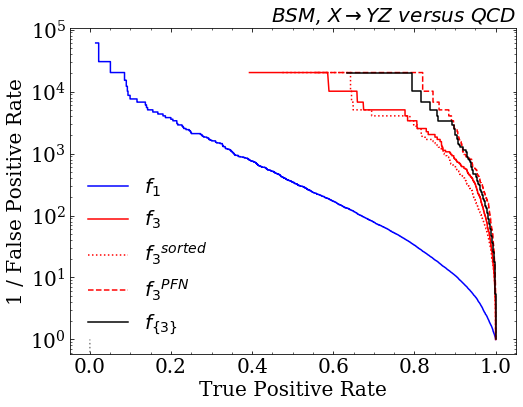

In [120]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(tpr_1D_phys,1./fpr_1D_phys,label="$f_{1}$",color="blue")
plt.plot(tpr_nD_phys,1./fpr_nD_phys,label="$f_{"+str(n_phys)+"}$",color="red")
plt.plot(tpr_nD_sort_phys,1./fpr_nD_sort_phys,label="$f_{"+str(n_phys)+"}$${}^{sorted}$",ls=":",color="red")
plt.plot(tpr_nD_phys_pfn,1./fpr_nD_phys_pfn,label="$f_{"+str(n_phys)+"}$${}^{PFN}$",ls="--",color="red")
plt.plot(tpr_nD_from1D_phys,1./fpr_nD_from1D_phys,label="$f_{\{"+str(n_phys)+"\}}$",color="black")
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=20)
plt.ylabel("1 / False Positive Rate",fontsize=20)
plt.yscale("log")
plt.legend(frameon=False,fontsize=20)
plt.title(r"$BSM$, $X\rightarrow YZ$ $versus$ $QCD$",loc="right",fontsize=20)

plt.savefig("ensembleLearnPlots/BSM_ROC.pdf",bbox_inches='tight')

In [41]:
#Now, use a custom PFN loss

In [42]:
Phi_sizes, F_sizes = (100, 100, 128, 1), []
pfn_v2 = PFN(input_dim=X_nD_val_phys_pfn.shape[-1], Phi_sizes=Phi_sizes, F_sizes=F_sizes, F_acts='linear', output_dim=1, output_act='linear', Phi_acts=['relu','relu','relu','linear'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_8[0][0]               
__________________________________________________________________________________________________
activation

In [43]:
pfn_v2.model.layers.pop()
pfn_v2.model.layers.pop()
for layer in pfn_v2.model.layers:
    print(layer)

In [44]:
def myloss(y_true, y_pred):
    
    return binary_crossentropy(y_true,K.exp(y_pred)/(1.+K.exp(y_pred)))

In [45]:
pfn_v2.model.compile(loss=lambda y_true, y_pred: myloss(y_true, y_pred), optimizer='adam', metrics=['accuracy'])

In [46]:
pfn_v2.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_8 (Activation)       (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_8[0][0]               
__________________________________________________________________________________________________
activation

In [47]:
historyf_v2 = pfn_v2.fit(X_nD_train_phys_pfn, Y_nD_train_phys,
          epochs=50,
          batch_size=batch_size,
          validation_data=(X_nD_val_phys_pfn, Y_nD_val_phys),
          verbose=1)

Train on 32774 samples, validate on 32775 samples
Epoch 1/50
32774/32774 [==============================] - 1s 21us/step - loss: 0.2541 - acc: 0.1344 - val_loss: 0.1095 - val_acc: 0.0467
Epoch 2/50
32774/32774 [==============================] - 0s 3us/step - loss: 0.0998 - acc: 0.0346 - val_loss: 0.0879 - val_acc: 0.0256
Epoch 3/50
32774/32774 [==============================] - 0s 3us/step - loss: 0.0874 - acc: 0.0216 - val_loss: 0.0832 - val_acc: 0.0204
Epoch 4/50
32774/32774 [==============================] - 0s 3us/step - loss: 0.0817 - acc: 0.0196 - val_loss: 0.0770 - val_acc: 0.0195
Epoch 5/50
32774/32774 [==============================] - 0s 3us/step - loss: 0.0750 - acc: 0.0194 - val_loss: 0.0707 - val_acc: 0.0190
Epoch 6/50
32774/32774 [==============================] - 0s 3us/step - loss: 0.0688 - acc: 0.0202 - val_loss: 0.0657 - val_acc: 0.0198
Epoch 7/50
32774/32774 [==============================] - 0s 3us/step - loss: 0.0640 - acc: 0.0209 - val_loss: 0.0616 - val_acc: 0.01

In [48]:
scores_nD_phys_pfn_v2 = pfn_v2.predict(X_nD_val_phys_pfn,batch_size=int(0.1*len(X_nD_train_phys)))

In [49]:
fpr_nD_phys_pfn_v2, tpr_nD_phys_pfn_v2, _ = roc_curve(Y_nD_val_phys, scores_nD_phys_pfn_v2)

/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in true_divide
  """Entry point for launching an IPython kernel.
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


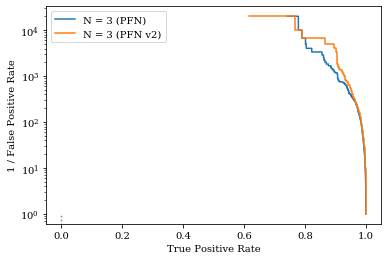

In [50]:
plt.plot(tpr_nD_phys_pfn,1./fpr_nD_phys_pfn,label="N = "+str(n_phys)+" (PFN)")
plt.plot(tpr_nD_phys_pfn_v2,1./fpr_nD_phys_pfn_v2,label="N = "+str(n_phys)+" (PFN v2)")
plt.plot([1,0],[0,1],ls=":",color="grey")
plt.xlabel("True Positive Rate")
plt.ylabel("1 / False Positive Rate")
plt.yscale("log")
plt.legend()

In [51]:
for layer in pfn_v2.model.layers:
    print(layer.name,layer.output_shape)

input (None, None, 4)
tdist_0 (None, None, 100)
activation_8 (None, None, 100)
tdist_1 (None, None, 100)
activation_9 (None, None, 100)
tdist_2 (None, None, 128)
activation_10 (None, None, 128)
tdist_3 (None, None, 1)
mask (None, None)
activation_11 (None, None, 1)
sum (None, 1)


In [52]:
from keras.models import Model

In [53]:
myPhi = Model(input = pfn_v2.model.input,output = pfn_v2.model.layers[-2].output)

/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`
  """Entry point for launching an IPython kernel.


In [54]:
myPhi_preds = myPhi.predict(X_nD_val_phys_pfn,batch_size=int(0.1*len(X_nD_train_phys)))

In [55]:
preds_Phi = np.reshape(myPhi_preds,[n_phys*len(myPhi_preds)])
Y_Phi = [[Y_nD_val_phys[i],Y_nD_val_phys[i],Y_nD_val_phys[i]] for i in range(len(Y_nD_val_phys))]
Y_Phi = np.reshape(Y_Phi,[n_phys*len(Y_Phi)])

In [56]:
fpr_Phi, tpr_Phi, _ = roc_curve(Y_Phi, preds_Phi)

/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  
/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


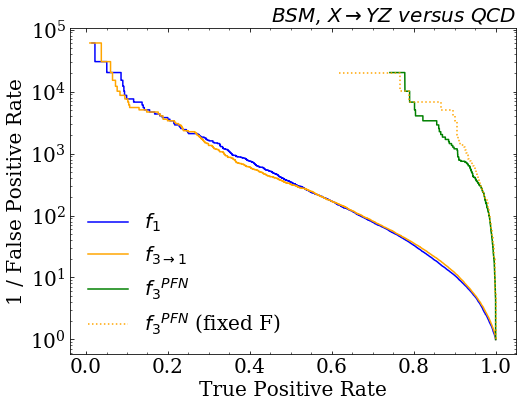

In [85]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(tpr_1D_phys,1./fpr_1D_phys,label="$f_{1}$",color="blue")
plt.plot(tpr_Phi,1./fpr_Phi,label=r"$f_{3\rightarrow 1}$",color="orange")

plt.plot(tpr_nD_phys_pfn,1./fpr_nD_phys_pfn,label="$f_{"+str(n_phys)+"}$${}^{PFN}$",color="green")
plt.plot(tpr_nD_phys_pfn_v2,1./fpr_nD_phys_pfn_v2,label="$f_{"+str(n_phys)+"}$${}^{PFN}$ (fixed F)",color="orange",ls=":")

plt.xlabel("True Positive Rate",fontsize=20)
plt.ylabel("1 / False Positive Rate",fontsize=20)
plt.yscale("log")
plt.legend(frameon=False,fontsize=20)

plt.title(r"$BSM$, $X\rightarrow YZ$ $versus$ $QCD$",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/BSM_ROC2.pdf",bbox_inches='tight')

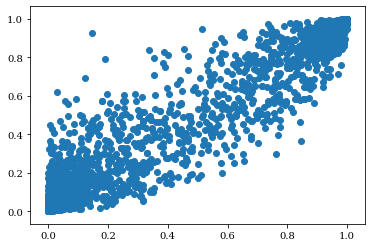

In [135]:
plt.scatter(scores_nD_phys_pfn[:,1],np.exp(scores_nD_phys_pfn_v2)/(1+np.exp(scores_nD_phys_pfn_v2)))

## Now let's do a harder classification task - top quark mass

In [58]:
test_dataset_0 = np.load('/data0/bpnachman/topmass/SRGN_Mt_default.npz')
test_dataset_1 = np.load('/data0/bpnachman/topmass/SRGN_Mt_unknown.npz')

In [59]:
def preprocess_data(X):
    return X / 1000.

In [60]:
X0_test_G = preprocess_data(test_dataset_0['generator'])
X0_test_S = preprocess_data(test_dataset_0['simulation'])
X1_test_G = preprocess_data(test_dataset_1['generator'])
X1_test_S = preprocess_data(test_dataset_1['simulation'])

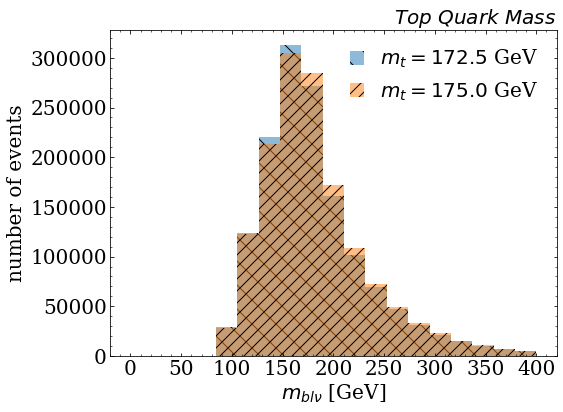

In [61]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

_,_,_=plt.hist(X0_test_S[:,0]*1000,bins=np.linspace(0,400,20),alpha=0.5,label="$m_t = 172.5$ GeV",hatch='\\')
_,_,_=plt.hist(X1_test_S[:,0]*1000,bins=np.linspace(0,400,20),alpha=0.5,label="$m_t = 175.0$ GeV",hatch='//')
plt.xlabel(r"$m_{bl\nu}$ [GeV]",fontsize=20)
plt.legend(frameon=False,fontsize=20,handlelength=0.7)
plt.ylabel("number of events",fontsize=20)

plt.title(r"$Top$ $Quark$ $Mass$",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/Top_Features.pdf",bbox_inches='tight')

In [62]:
n_top = 20

X0_test_S = preprocess_data(test_dataset_0['generator'])
X1_test_S = preprocess_data(test_dataset_1['generator'])

X0_test_S = X0_test_S[0:len(X0_test_S) - len(X0_test_S) % n_top]
X1_test_S = X1_test_S[0:len(X1_test_S) - len(X1_test_S) % n_top]

X_1D_top = np.concatenate([X0_test_S,X1_test_S])
Y_1D_top = np.concatenate([np.ones(len(X0_test_S)),np.zeros(len(X1_test_S))])
    
X_nD_top = np.reshape(X_1D_top,[int(len(X_1D_top)/n_top),4*n_top])
Y_nD_top = np.concatenate([np.ones(int(len(X0_test_S)/n_top)),np.zeros(int(len(X1_test_S)/n_top))])

scaler_top = preprocessing.StandardScaler().fit(X_nD_top)
X_nD_top = scaler_top.transform(X_nD_top)

scaler_1D_top = preprocessing.StandardScaler().fit(X_1D_top)
X_1D_top = scaler_1D_top.transform(X_1D_top)

X_1D_top_train, X_1D_top_val, Y_1D_top_train, Y_1D_top_val = train_test_split(X_1D_top, Y_1D_top, test_size=0.5)
X_nD_top_train, X_nD_top_val, Y_nD_top_train, Y_nD_top_val = train_test_split(X_nD_top, Y_nD_top, test_size=0.5)

In [63]:
model1D_top = Sequential()
model1D_top.add(Dense(128, activation='relu',input_shape =(4,))) 
model1D_top.add(Dense(128, activation='relu'))
model1D_top.add(Dense(1, activation='sigmoid'))
model1D_top.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_top_model1D= model1D_top.fit(X_1D_top_train, Y_1D_top_train, epochs=20, batch_size=int(0.1*len(X_1D_top_train)),validation_data=(X_1D_top_val, Y_1D_top_val))

modelnD_top = Sequential()
modelnD_top.add(Dense(128, activation='relu',input_shape =(4*n_top,))) 
modelnD_top.add(Dense(128, activation='relu'))
modelnD_top.add(Dense(1, activation='sigmoid'))
modelnD_top.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hist_top_modelnD= modelnD_top.fit(X_nD_top_train, Y_nD_top_train, epochs=20, batch_size=int(0.1*len(X_nD_top_train)),validation_data=(X_nD_top_val, Y_nD_top_val))

scores_1D_top = model1D_top.predict(X_1D_top_val)
scores_nD_top = modelnD_top.predict(X_nD_top_val)

scores_1D_fromnD_top = model1D_top.predict(scaler_1D_top.transform(np.reshape(scaler_top.inverse_transform(X_nD_top_val),[n_top*len(X_nD_top_val),4])),batch_size=int(0.1*len(X_nD_top_train)))
#scores_1D_fromnD_top = model1D_top.predict(np.reshape(X_nD_top_val,[n*len(X_nD_top_val)]))
scores_1D_fromnD_top = np.reshape(scores_1D_fromnD_top,[int(len(scores_1D_fromnD_top)/n_top),n_top])

scaled_up_top = np.array([np.prod(scores_1D_fromnD_top[i,:] / (1.-scores_1D_fromnD_top[i,:])) for i in range(len(scores_1D_fromnD_top))])

fpr_1D_top, tpr_1D_top, _ = roc_curve(Y_1D_top_val, scores_1D_top)
fpr_nD_top, tpr_nD_top, _ = roc_curve(Y_nD_top_val, scores_nD_top)
fpr_nD_from1D_top, tpr_nD_from1D_top, _ = roc_curve(Y_nD_top_val, scaled_up_top)

Train on 1452070 samples, validate on 1452070 samples
Epoch 1/20
1452070/1452070 [==============================] - 2s 1us/step - loss: 0.6936 - acc: 0.5084 - val_loss: 0.6930 - val_acc: 0.5119
Epoch 2/20
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6927 - acc: 0.5147 - val_loss: 0.6928 - val_acc: 0.5144
Epoch 3/20
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6925 - acc: 0.5167 - val_loss: 0.6925 - val_acc: 0.5173
Epoch 4/20
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6923 - acc: 0.5185 - val_loss: 0.6924 - val_acc: 0.5169
Epoch 5/20
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6922 - acc: 0.5183 - val_loss: 0.6923 - val_acc: 0.5181
Epoch 6/20
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6922 - acc: 0.5193 - val_loss: 0.6922 - val_acc: 0.5185
Epoch 7/20
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6921 - acc: 0.5199 - v

/home/bpnachman/anaconda3/envs/shared_env2/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


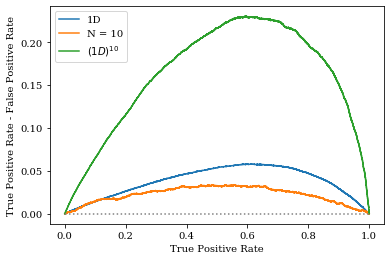

In [64]:
plt.plot(tpr_1D_top,1-fpr_1D_top-(1-tpr_1D_top),label="1D")
plt.plot(tpr_nD_top,1-fpr_nD_top-(1-tpr_nD_top),label="N = 10")
plt.plot(tpr_nD_from1D_top,1-fpr_nD_from1D_top-(1-tpr_nD_from1D_top),label="$(1D)^{10}$")
plt.plot([0,1],[0,0],ls=":",color="grey")
plt.xlabel("True Positive Rate")
plt.ylabel("True Positive Rate - False Positive Rate")
plt.legend()

In [65]:
X_nD_val_top_pfn = np.reshape(X_nD_top_val,[len(X_nD_top_val),n_top,4])
X_nD_train_top_pfn = np.reshape(X_nD_top_train,[len(X_nD_top_train),n_top,4])

Phi_sizes_top, F_sizes_top = (100, 100, 128), (100, 100, 100)
pfn_top = PFN(input_dim=X_nD_val_top_pfn.shape[-1], Phi_sizes=Phi_sizes_top, F_sizes=F_sizes_top)
num_epoch = 100
batch_size = 5000 #was 5000
historyf_top = pfn_top.fit(X_nD_train_top_pfn, to_categorical(Y_nD_top_train,2),
          epochs=num_epoch,
          batch_size=batch_size,
          validation_data=(X_nD_val_top_pfn, to_categorical(Y_nD_top_val,2)),
        verbose=1)
scores_nD_tops_pfn = pfn_top.predict(X_nD_val_top_pfn,batch_size=int(0.1*len(X_nD_top_train)))
fpr_nD_top_pfn, tpr_nD_top_pfn, _ = roc_curve(Y_nD_top_val, scores_nD_tops_pfn[:,1])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_13 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_13[0][0]              
__________________________________________________________________________________________________
activation

72603/72603 [==============================] - 0s 4us/step - loss: 0.6811 - acc: 0.5715 - val_loss: 0.6748 - val_acc: 0.5780
Epoch 32/100
72603/72603 [==============================] - 0s 4us/step - loss: 0.6706 - acc: 0.5844 - val_loss: 0.6978 - val_acc: 0.5497
Epoch 33/100
72603/72603 [==============================] - 0s 4us/step - loss: 0.6698 - acc: 0.5867 - val_loss: 0.6741 - val_acc: 0.5811
Epoch 34/100
72603/72603 [==============================] - 0s 4us/step - loss: 0.6681 - acc: 0.5903 - val_loss: 0.6734 - val_acc: 0.5824
Epoch 35/100
72603/72603 [==============================] - 0s 4us/step - loss: 0.6679 - acc: 0.5910 - val_loss: 0.6742 - val_acc: 0.5798
Epoch 36/100
72603/72603 [==============================] - 0s 4us/step - loss: 0.6672 - acc: 0.5919 - val_loss: 0.6732 - val_acc: 0.5818
Epoch 37/100
72603/72603 [==============================] - 0s 4us/step - loss: 0.6654 - acc: 0.5947 - val_loss: 0.6769 - val_acc: 0.5775
Epoch 38/100
72603/72603 [=====================

72603/72603 [==============================] - 0s 4us/step - loss: 0.6398 - acc: 0.6296 - val_loss: 0.6639 - val_acc: 0.5999
Epoch 91/100
72603/72603 [==============================] - 0s 4us/step - loss: 0.6381 - acc: 0.6315 - val_loss: 0.6552 - val_acc: 0.6106
Epoch 92/100
72603/72603 [==============================] - 0s 4us/step - loss: 0.6395 - acc: 0.6324 - val_loss: 0.6692 - val_acc: 0.5947
Epoch 93/100
72603/72603 [==============================] - 0s 4us/step - loss: 0.6386 - acc: 0.6333 - val_loss: 0.6558 - val_acc: 0.6102
Epoch 94/100
72603/72603 [==============================] - 0s 4us/step - loss: 0.6350 - acc: 0.6361 - val_loss: 0.6535 - val_acc: 0.6151
Epoch 95/100
72603/72603 [==============================] - 0s 4us/step - loss: 0.6440 - acc: 0.6268 - val_loss: 0.6576 - val_acc: 0.6087
Epoch 96/100
72603/72603 [==============================] - 0s 4us/step - loss: 0.6360 - acc: 0.6348 - val_loss: 0.6535 - val_acc: 0.6144
Epoch 97/100
72603/72603 [=====================

In [146]:
#Save everything
np.save("ensemblelearning/Y_1D_top_val",Y_1D_top_val)
np.save("ensemblelearning/Y_1D_top_val",Y_1D_top_val)
np.save("ensemblelearning/Y_1D_top_train",Y_1D_top_train)
np.save("ensemblelearning/X_1D_top_train",X_1D_top_train)

np.save("ensemblelearning/Y_nD_top_val",Y_nD_top_val)
np.save("ensemblelearning/Y_nD_top_val",Y_nD_top_val)
np.save("ensemblelearning/Y_nD_top_train",Y_nD_top_train)
np.save("ensemblelearning/X_nD_top_train",X_nD_top_train)

model_json = model1D_top.to_json()
with open("ensemblelearning/model1D_top.json", "w") as json_file:
    json_file.write(model_json)
model1D_top.save_weights("ensemblelearning/model1D_top.h5")

model_json = modelnD_top.to_json()
with open("ensemblelearning/modelnD_top.json", "w") as json_file:
    json_file.write(model_json)
modelnD_top.save_weights("ensemblelearning/modelnD_top.h5")

model_json = pfn_top.model.to_json()
with open("ensemblelearning/model_pfn_top.json", "w") as json_file:
    json_file.write(model_json)
pfn_top.model.save_weights("ensemblelearning/model_pfn_top.h5")

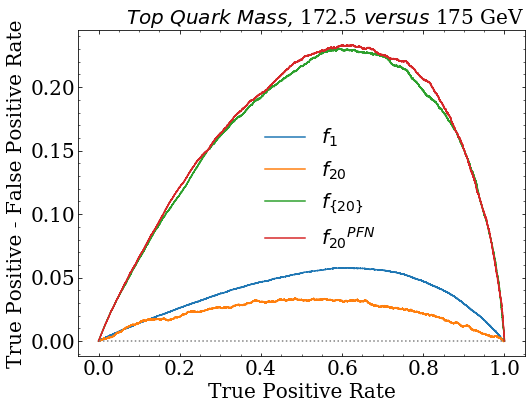

In [82]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

plt.plot(tpr_1D_top,1-fpr_1D_top-(1-tpr_1D_top),label="$f_{1}$")
plt.plot(tpr_nD_top,1-fpr_nD_top-(1-tpr_nD_top),label="$f_{"+str(n_top)+"}$")
plt.plot(tpr_nD_from1D_top,1-fpr_nD_from1D_top-(1-tpr_nD_from1D_top),label="$f_{\{"+str(n_top)+"\}}$")
plt.plot(tpr_nD_top_pfn,1-fpr_nD_top_pfn-(1-tpr_nD_top_pfn),label="$f_{"+str(n_top)+"}$${}^{PFN}$")
plt.plot([0,1],[0,0],ls=":",color="grey")
plt.xlabel("True Positive Rate",fontsize=20)
plt.ylabel("True Positive - False Positive Rate",fontsize=20)
plt.legend(frameon=False,fontsize=20,loc=(0.4,0.3))

plt.title(r"$Top$ $Quark$ $Mass$, 172.5 $versus$ 175 GeV",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/Top_ROC.pdf",bbox_inches='tight')

In [68]:
Phi_sizes_top, F_sizes_top = (100, 100, 128), (100, 100, 100)
pfn_top_1e = PFN(input_dim=X_nD_val_top_pfn.shape[-1], Phi_sizes=Phi_sizes_top, F_sizes=F_sizes_top)
num_epoch = 100
batch_size = 5000 #was 5000

tprs_pfn = []
fprs_pfn = []
vallosses_pfn = []
trainlosses_pfn = []
for i in range(num_epoch):
    print("on epoch",i)
    historyf_top_1e = pfn_top_1e.fit(X_nD_train_top_pfn, to_categorical(Y_nD_top_train,2),epochs=1,batch_size=batch_size,validation_data=(X_nD_val_top_pfn, to_categorical(Y_nD_top_val,2)),verbose=1)
    scores_nD_tops_pfn_1e = pfn_top_1e.predict(X_nD_val_top_pfn,batch_size=int(0.1*len(X_nD_top_train)))
    fpr_nD_top_pfn_1e, tpr_nD_top_pfn_1e, _ = roc_curve(Y_nD_top_val, scores_nD_tops_pfn_1e[:,1])
    tprs_pfn+=[tpr_nD_top_pfn_1e]
    fprs_pfn+=[fpr_nD_top_pfn_1e]
    vallosses_pfn+=[historyf_top_1e.history['val_loss'][0]]
    trainlosses_pfn+=[historyf_top_1e.history['loss'][0]]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, None, 4)      0                                            
__________________________________________________________________________________________________
tdist_0 (TimeDistributed)       (None, None, 100)    500         input[0][0]                      
__________________________________________________________________________________________________
activation_20 (Activation)      (None, None, 100)    0           tdist_0[0][0]                    
__________________________________________________________________________________________________
tdist_1 (TimeDistributed)       (None, None, 100)    10100       activation_20[0][0]              
__________________________________________________________________________________________________
activation

72603/72603 [==============================] - 0s 4us/step - loss: 0.7123 - acc: 0.5509 - val_loss: 0.6833 - val_acc: 0.5674
on epoch 22
Train on 72603 samples, validate on 72604 samples
Epoch 1/1
72603/72603 [==============================] - 0s 4us/step - loss: 0.6764 - acc: 0.5776 - val_loss: 0.6783 - val_acc: 0.5729
on epoch 23
Train on 72603 samples, validate on 72604 samples
Epoch 1/1
72603/72603 [==============================] - 0s 4us/step - loss: 0.6694 - acc: 0.5872 - val_loss: 0.6843 - val_acc: 0.5681
on epoch 24
Train on 72603 samples, validate on 72604 samples
Epoch 1/1
72603/72603 [==============================] - 0s 4us/step - loss: 0.6748 - acc: 0.5812 - val_loss: 0.6771 - val_acc: 0.5757
on epoch 25
Train on 72603 samples, validate on 72604 samples
Epoch 1/1
72603/72603 [==============================] - 0s 4us/step - loss: 0.6734 - acc: 0.5829 - val_loss: 0.6766 - val_acc: 0.5766
on epoch 26
Train on 72603 samples, validate on 72604 samples
Epoch 1/1
72603/72603 [==

on epoch 63
Train on 72603 samples, validate on 72604 samples
Epoch 1/1
72603/72603 [==============================] - 0s 4us/step - loss: 0.6593 - acc: 0.6036 - val_loss: 0.6675 - val_acc: 0.5943
on epoch 64
Train on 72603 samples, validate on 72604 samples
Epoch 1/1
72603/72603 [==============================] - 0s 4us/step - loss: 0.6555 - acc: 0.6087 - val_loss: 0.6905 - val_acc: 0.5668
on epoch 65
Train on 72603 samples, validate on 72604 samples
Epoch 1/1
72603/72603 [==============================] - 0s 4us/step - loss: 0.6510 - acc: 0.6161 - val_loss: 0.6646 - val_acc: 0.5997
on epoch 66
Train on 72603 samples, validate on 72604 samples
Epoch 1/1
72603/72603 [==============================] - 0s 4us/step - loss: 0.6545 - acc: 0.6106 - val_loss: 0.6636 - val_acc: 0.5995
on epoch 67
Train on 72603 samples, validate on 72604 samples
Epoch 1/1
72603/72603 [==============================] - 0s 4us/step - loss: 0.6494 - acc: 0.6181 - val_loss: 0.6623 - val_acc: 0.6013
on epoch 68
Tra

In [69]:
tprs = []
fprs = []
vallosses = []
trainlosses = []

model1D_top_1e = Sequential()
model1D_top_1e.add(Dense(128, activation='relu',input_shape =(4,))) 
model1D_top_1e.add(Dense(128, activation='relu'))
model1D_top_1e.add(Dense(1, activation='sigmoid'))
model1D_top_1e.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

for i in range(num_epoch):
    print("on epoch",i)

    hist_top_model1D_1e= model1D_top_1e.fit(X_1D_top_train, Y_1D_top_train, epochs=1, batch_size=int(0.1*len(X_1D_top_train)),validation_data=(X_1D_top_val, Y_1D_top_val))
    scores_1D_top_1e = model1D_top_1e.predict(X_1D_top_val,batch_size=int(0.1*len(X_1D_top_train)))

    scores_1D_fromnD_top_1e = model1D_top_1e.predict(scaler_1D_top.transform(np.reshape(scaler_top.inverse_transform(X_nD_top_val),[n_top*len(X_nD_top_val),4])),batch_size=int(0.1*len(X_nD_top_train)))
    scores_1D_fromnD_top_1e = np.reshape(scores_1D_fromnD_top_1e,[int(len(scores_1D_fromnD_top_1e)/n_top),n_top])
    scaled_up_top_1e = np.array([np.prod(scores_1D_fromnD_top_1e[i,:] / (1.-scores_1D_fromnD_top_1e[i,:])) for i in range(len(scores_1D_fromnD_top_1e))])

    fpr_nD_from1D_top_1e, tpr_nD_from1D_top_1e, _ = roc_curve(Y_nD_top_val, scaled_up_top_1e)
    
    tprs+=[tpr_nD_from1D_top_1e]
    fprs+=[fpr_nD_from1D_top_1e]
    vallosses+=[hist_top_model1D_1e.history['val_loss'][0]]
    trainlosses+=[hist_top_model1D_1e.history['loss'][0]]

on epoch 0
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 2s 1us/step - loss: 0.6935 - acc: 0.5089 - val_loss: 0.6929 - val_acc: 0.5137
on epoch 1
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6927 - acc: 0.5142 - val_loss: 0.6926 - val_acc: 0.5144
on epoch 2
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6924 - acc: 0.5175 - val_loss: 0.6924 - val_acc: 0.5172
on epoch 3
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6923 - acc: 0.5180 - val_loss: 0.6923 - val_acc: 0.5176
on epoch 4
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6922 - acc: 0.5187 - val_loss: 0.692

1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6895 - acc: 0.5328 - val_loss: 0.6897 - val_acc: 0.5317
on epoch 41
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6895 - acc: 0.5328 - val_loss: 0.6897 - val_acc: 0.5313
on epoch 42
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6895 - acc: 0.5329 - val_loss: 0.6897 - val_acc: 0.5306
on epoch 43
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6895 - acc: 0.5323 - val_loss: 0.6897 - val_acc: 0.5317
on epoch 44
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6895 - acc: 0.5324 - val_loss: 0.6898 - val_acc: 0.5308
on epoch 45
Train on 1452070 samples, validate on 1

1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6890 - acc: 0.5344 - val_loss: 0.6893 - val_acc: 0.5333
on epoch 81
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6890 - acc: 0.5344 - val_loss: 0.6893 - val_acc: 0.5328
on epoch 82
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6890 - acc: 0.5346 - val_loss: 0.6893 - val_acc: 0.5328
on epoch 83
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6890 - acc: 0.5345 - val_loss: 0.6893 - val_acc: 0.5326
on epoch 84
Train on 1452070 samples, validate on 1452070 samples
Epoch 1/1
1452070/1452070 [==============================] - 1s 1us/step - loss: 0.6890 - acc: 0.5352 - val_loss: 0.6893 - val_acc: 0.5325
on epoch 85
Train on 1452070 samples, validate on 1

In [70]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx #array[idx]

In [71]:
fprat50s = [fprs[i][find_nearest(tprs[i],0.5)] for i in range(len(tprs))]
fprat50s_pfn = [fprs_pfn[i][find_nearest(tprs_pfn[i],0.5)] for i in range(len(fprs_pfn))]

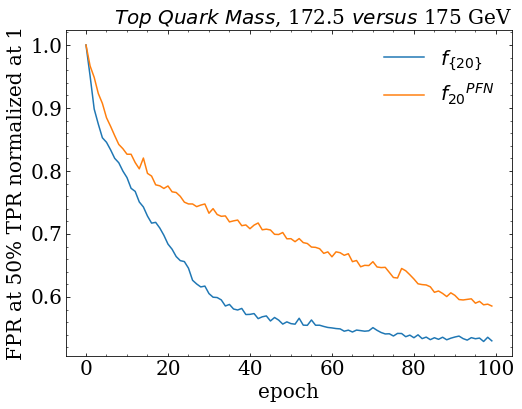

In [81]:
fig = plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 1) 
ax0 = plt.subplot(gs[0])
ax0.yaxis.set_ticks_position('both')
ax0.xaxis.set_ticks_position('both')
ax0.tick_params(direction="in",which="both")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax0.minorticks_on()

#plt.plot(fprat50s/fprat50s[0],label="$f_{\{20\}}$")
#plt.plot(fprat50s_pfn/fprat50s_pfn[0],label="$f_{20}$ (PFN)")

plt.plot(fprat50s/fprat50s[0],label="$f_{\{20\}}$")
plt.plot(fprat50s_pfn/fprat50s_pfn[0],label="$f_{20}$${}^{PFN}$")

plt.legend(frameon=False,fontsize=20)
plt.xlabel("epoch",fontsize=20)
plt.ylabel("FPR at 50% TPR normalized at 1",fontsize=20)

plt.title(r"$Top$ $Quark$ $Mass$, 172.5 $versus$ 175 GeV",loc="right",fontsize=20)
plt.savefig("ensembleLearnPlots/Top_LearningRate.pdf",bbox_inches='tight')